<a href="https://colab.research.google.com/github/rubencg195/Pytorch-Tutorials/blob/master/Machine%20Learning%20-%20Face%20Recognition%20CNN%20Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports and Libraries

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [114]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils



# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
%matplotlib inline
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


**Source: **

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html


A lot of effort in solving any machine learning problem goes in to preparing the data. PyTorch provides many tools to make data loading easy and hopefully, to make your code more readable. In this tutorial, we will see how to load and preprocess/augment data from a non trivial dataset.

The dataset we are going to deal with is that of facial pose. This means that a face is annotated like this:

![alt text](https://pytorch.org/tutorials/_images/landmarked_face2.png)

Download the dataset from 

https://download.pytorch.org/tutorial/faces.zip 

so that the images are in a directory named 

**‘data/faces/’**

This dataset was actually generated by applying excellent **dlib’s pose estimation** on a few images from imagenet tagged as ‘face’.

http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html

Dataset comes with a csv file with annotations which looks like this:



```
image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
0805personali01.jpg,27,83,27,98, ... 84,134
1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312
```

Let’s quickly read the CSV and get the annotations in an (N, 2) array where N is the number of landmarks.










In [55]:
!wget https://download.pytorch.org/tutorial/faces.zip
!unzip faces.zip
!ls && ls faces

--2018-12-13 18:05:41--  https://download.pytorch.org/tutorial/faces.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.80.22, 13.32.80.53, 13.32.80.97, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.80.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5780252 (5.5M) [application/zip]
Saving to: ‘faces.zip.3’

faces.zip.3         100%[===================>]   5.51M  22.1MB/s    in 0.2s    

2018-12-13 18:05:41 (22.1 MB/s) - ‘faces.zip.3’ saved [5780252/5780252]

Archive:  faces.zip
replace faces/0805personali01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: faces/0805personali01.jpg  
  inflating: faces/1084239450_e76e00b7e7.jpg  
  inflating: faces/10comm-decarlo.jpg  
  inflating: faces/110276240_bec305da91.jpg  
  inflating: faces/1198_0_861.jpg    
  inflating: faces/137341995_e7c48e9a75.jpg  
  inflating: faces/1383023626_8a49e4879a.jpg  
  inflating: faces/144044282_87cf3ff76e.jpg  
  inflating: faces/15260

In [56]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

n = 65 # Number of landmarks
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


Let’s write a simple helper function to show an image and its landmarks and use it to show a sample.

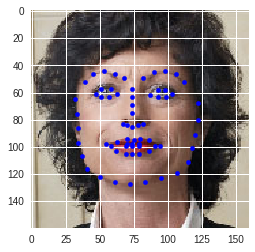

In [57]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=80, marker='.', c='b')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
img_name = "faces/person-7.jpg"
img = io.imread(img_name)
show_landmarks(img, landmarks)
plt.show()

DATASET CLASS


**torch.utils.data.Dataset** is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

**\__len__** so that len(dataset) returns the size of the dataset.
**\__getitem__** to support the indexing such that dataset[i] can be used to get ith sample
Let’s create a dataset class for our face landmarks dataset. We will read the csv in **\__init__**  It leave the reading of images to**\__getitem__** . This is memory efficient because all the images are not stored in the memory at once but read as required.

Sample of our dataset will be a dict

`{
'image': image, 
'landmarks': landmarks
}`

Our datset will take an optional argument transform so that any required processing can be applied on the sample. We will see the usefulness of transform in the next section.



#Dataset Transformation

In [0]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

Let’s instantiate this class and iterate through the data samples. We will print the sizes of first 4 samples and show their landmarks.

0 (324, 215, 3) (68, 2)


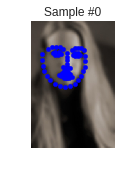

1 (500, 333, 3) (68, 2)


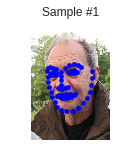

2 (250, 258, 3) (68, 2)


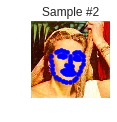

3 (434, 290, 3) (68, 2)


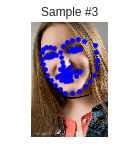

In [59]:
face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                    root_dir='faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

TRANSFORMS


One issue we can see from the above is that the samples are not of the same size. Most neural networks expect the images of a fixed size. Therefore, we will need to write some prepocessing code. Let’s create three transforms:

1. Rescale: to scale the image
2. RandomCrop: to crop from image randomly. This is data augmentation.
3. ToTensor: to convert the numpy images to torch images (we need to swap axes).


We will write them as callable classes instead of simple functions so that parameters of the transform need not be passed everytime it’s called. For this, we just need to implement **\__call__** method and if required,**\__init__** method. We can then use a transform like this:



```
tsfm = Transform(params)
transformed_sample = tsfm(sample)
```

*Observe below how these transforms had to be applied both on the image and landmarks.*



In [0]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

Compose transforms


Now, we apply the transforms on an sample.

Let’s say we want to rescale the shorter side of the image to 256 and then randomly crop a square of size 224 from it. i.e, we want to compose Rescale and RandomCrop transforms. torchvision.transforms.Compose is a simple callable class which allows us to do this.

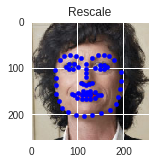

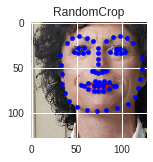

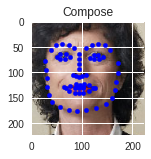

In [61]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

ITERATING THROUGH THE DATASET


Let’s put this all together to create a dataset with composed transforms. To summarize, every time this dataset is sampled:

An image is read from the file on the fly
Transforms are applied on the read image
Since one of the transforms is random, data is augmentated on sampling
We can iterate over the created dataset with a for i in range loop as before.

In [62]:
transformed_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                           root_dir='faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

1. Batching the data
2. Shuffling the data
3. Load the data in parallel using multiprocessing workers.


**torch.utils.data.DataLoader** is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using *collate_fn* . However, default collate should work fine for most use cases.





0 torch.Size([3, 3, 224, 224]) torch.Size([3, 68, 2])
1 torch.Size([3, 3, 224, 224]) torch.Size([3, 68, 2])
2 torch.Size([3, 3, 224, 224]) torch.Size([3, 68, 2])
3 torch.Size([3, 3, 224, 224]) torch.Size([3, 68, 2])


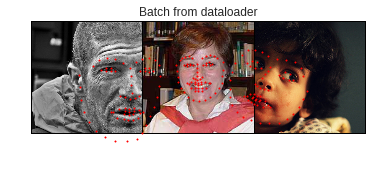

In [73]:
dataloader = DataLoader(transformed_dataset, batch_size=3,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

AFTERWORD: TORCHVISION
In this tutorial, we have seen how to write and use datasets, transforms and dataloader. torchvision package provides some common datasets and transforms. You might not even have to write custom classes. One of the more generic datasets available in torchvision is ImageFolder. It assumes that images are organized in the following way:


```
root/ants/xxx.png
root/ants/xxy.jpeg
root/ants/xxz.png
.
.
.
root/bees/123.jpg
root/bees/nsdf3.png
root/bees/asd932_.png
```


where ‘ants’, ‘bees’ etc. are class labels. Similarly generic transforms which operate on PIL.Image like RandomHorizontalFlip, Scale, are also available. You can use these to write a dataloader like this:

```
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)
                                             
                                             
```

#Model: Convolutional neural network (two convolutional layers)

In [64]:
def outputSize(in_size, kernel_size, stride, padding):
    
    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
    
    return (output)

print("Convolution #1")
#Input (3, 224, 224) Conv, Output specified = 18 for batch size. for Maxpool layer number 1 remains unchanged
print((18,
       outputSize(in_size=224, kernel_size=3, stride=1, padding=1),
       outputSize(in_size=224, kernel_size=3, stride=1, padding=1),
      ))
print("Maxpooling #1")
#Input (18, 224, 224) MaxPooling
print((18,
       outputSize(in_size=224, kernel_size=2, stride=2, padding=0),
       outputSize(in_size=224, kernel_size=2, stride=2, padding=0),
      ))
print("Convolution #2")
#Input (18, 224, 224) Conv, Output specified = 18 for batch size. for Maxpool layer number 1 remains unchanged
print((32,
       outputSize(in_size=112, kernel_size=3, stride=1, padding=1),
       outputSize(in_size=112, kernel_size=3, stride=1, padding=1),
      ))
print("Maxpooling #2")
#Input (18, 224, 224) MaxPooling
print((32,
       outputSize(in_size=112, kernel_size=2, stride=2, padding=0),
       outputSize(in_size=112, kernel_size=2, stride=2, padding=0),
      ))

Convolution #1
(18, 224, 224)
Maxpooling #1
(18, 112, 112)
Convolution #2
(32, 112, 112)
Maxpooling #2
(32, 56, 56)


In [0]:
num_classes = 68 * 2 #68 coordinates X and Y flattened

class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(18),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
        self.layer2 = nn.Sequential(
            nn.Conv2d(18, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
        self.fc = nn.Linear(32 * 56 * 56, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        #print("After Layer 1", out.shape)
        out = self.layer2(out)
        #print("After Layer 2", out.shape)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        #print("Final Layer Output Shape", out.shape)
        return out

In [0]:
class FaceLandmarksSubset(Dataset):
    """
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
    """
    def __init__(self, landmarks_frame, root_dir , transform=None):
      
        self.landmarks_frame = landmarks_frame
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return len(self.landmarks_frame)
      
def random_split(dataset, training_size):
    """
    Randomly split a dataset into non-overlapping new datasets of given lengths.

    Arguments:
        dataset (Dataset): Dataset to be split
        
    """

    return (
        FaceLandmarksSubset(
            dataset.landmarks_frame[0:training_size], 
            dataset.root_dir,
            transform=transforms.Compose([
                 Rescale(256),
                 RandomCrop(224),
                 ToTensor()
            ])
        ),
        FaceLandmarksSubset(
            dataset.landmarks_frame[training_size:],
            dataset.root_dir,
            transform=transforms.Compose([
                 Rescale(256),
                 RandomCrop(224),
                 ToTensor()
            ])
        )
   )

In [159]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

num_epochs = 15;
batch_size = 3;
learning_rate = 0.001;
data_limit = 2000

n_training_samples = 51 #int(len(transformed_dataset) * 0.6)
n_test_samples = 18 #int(len(transformed_dataset) * 0.4)

train_dataset ,test_dataset = random_split(
    transformed_dataset, 
    n_training_samples
)


print("DATASETS",
    len(transformed_dataset), 
    len(train_dataset),
    len(test_dataset) )

sample = transformed_dataset[i]
print("FULL DATASET SAMPLE", sample['image'].shape, sample['landmarks'].shape)
sample = train_dataset[i]
print("TRAINING DATASET SAMPLE", sample['image'].shape, sample['landmarks'].shape)

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=4)

test_loader = DataLoader(test_dataset , batch_size=batch_size,
                        shuffle=True, num_workers=4)

print("LOADERS",
    len(dataloader),
    len(train_loader),
    len(test_loader))


DATASETS 69 51 18
FULL DATASET SAMPLE torch.Size([3, 224, 224]) torch.Size([68, 2])
TRAINING DATASET SAMPLE torch.Size([3, 224, 224]) torch.Size([68, 2])
LOADERS 23 17 6


#Train the model

In [160]:
model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, sample_batched in enumerate(train_loader):
        #print(i, sample_batched['image'].size(),
        # sample_batched['landmarks'].size())
        
        images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
        
        images = images_batch
        labels = landmarks_batch.reshape(-1, 68 * 2)
        
        images = Variable(images.float())
        labels = Variable(labels)
        
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        #print("Label Shape", labels.shape, "Output Shape", outputs.shape)
        
        
        loss = criterion(outputs, labels.float())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 5 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/15], Step [5/17], Loss: -2278.5308
Epoch [1/15], Step [10/17], Loss: -1903.1104
Epoch [1/15], Step [15/17], Loss: -3527.7029
Epoch [2/15], Step [5/17], Loss: -3199.6187
Epoch [2/15], Step [10/17], Loss: -2781.7161
Epoch [2/15], Step [15/17], Loss: -2826.0327
Epoch [3/15], Step [5/17], Loss: -2838.8357
Epoch [3/15], Step [10/17], Loss: -2609.3499
Epoch [3/15], Step [15/17], Loss: -3014.2034
Epoch [4/15], Step [5/17], Loss: -1687.3500
Epoch [4/15], Step [10/17], Loss: -2617.1379
Epoch [4/15], Step [15/17], Loss: -2938.1619
Epoch [5/15], Step [5/17], Loss: -2963.7737
Epoch [5/15], Step [10/17], Loss: -3170.0674
Epoch [5/15], Step [15/17], Loss: -3775.7356
Epoch [6/15], Step [5/17], Loss: -2640.6643
Epoch [6/15], Step [10/17], Loss: -3220.6633
Epoch [6/15], Step [15/17], Loss: -2725.8606
Epoch [7/15], Step [5/17], Loss: -2233.6909
Epoch [7/15], Step [10/17], Loss: -2956.0818
Epoch [7/15], Step [15/17], Loss: -2373.2417
Epoch [8/15], Step [5/17], Loss: -3509.8914
Epoch [8/15], Step

#Test the Model

Predicted torch.Size([3, 136])


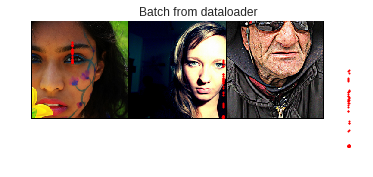

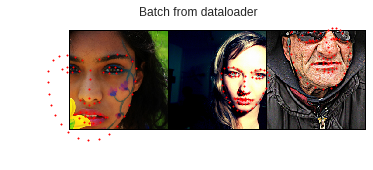

In [158]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for i, sample_batched in enumerate(train_loader):
        #print(i, sample_batched['image'].size(),
        # sample_batched['landmarks'].size())
        
        images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
        
        images = images_batch
        labels = landmarks_batch.reshape(-1, 68 * 2)
        
        images = Variable(images.float())
        labels = Variable(labels)
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        #_, predicted = torch.max(outputs.data, 1)
        #_, predicted = outputs.data
        print("Predicted", outputs.data.shape)
        
        if i_batch == 3:
          plt.figure()
          show_landmarks_batch({'image': images, 'landmarks': outputs.data.reshape(-1, 68, 2) })
          plt.axis('off')
          plt.ioff()
          plt.show()
          show_landmarks_batch({'image': images, 'landmarks': labels.reshape(-1, 68, 2) })
          plt.axis('off')
          plt.ioff()
          plt.show()
          break
        
        
        #total += labels.size(0)
        #correct += (predicted == labels).sum().item()

    #print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))


#Save the model

In [0]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

#Improve

1. Normalize Data
2.  Change Loss Function
3. Get More Data